# **British Airways Forage Data Science Task 2 Code Pipeline**

## **Author:** Mariah Noelle Cornelio

- **Data Obtained from Forage's British Airways Data Science Job Simulation:** https://www.theforage.com/simulations/british-airways/data-science-yqoz?reloaded=true
- **Task 2:** Predicting customer buying behavior

## **Outline for This Pipeline**

1. Understanding the task and background information
2. Load dataframe and packages
3. Exploratory data analysis
4. Data cleaning and feature engineering, if needed
5. Split and train data
6. Testing and cross-validation
7. Evaluation
8. Conclusion

### **Part 1: Understanding the task and background information**

For this task, we are given a customer booking .csv file containing the target variable "booking_complete" and 14 features like trip details and the customer's preferences during the flight. The task wants us to build a machine learning model that can predict if a customer will end up booking the flight. This is becuase back in the day without the internet, customers would just go to the airports and buy their tickets then and there. But now that the internet exists, customers are able to book their flights online and have access to details such as any preferred seating, excess baggage, or in-flight meals. 

To build a machine learning model, we must look at the type of problem that is given to us. First, is it supervised or unsupervised. If the target variable is defined, then it is supervised. If the target variable is not defined, it is unsupervised. In this case, our target variable is defined, therefore we will use supervised model methods. Next, we must look at the target variable itself and determine if it is numerical/continuous or categorical. If categorical, we can use classification models like Random Forest, Logistic Regression, SVM, etc. depending if it is also binary or multiclass. If numerical, we can use regression models. 

In the data given, the target variable is a binary classification variable. Because it is either 0 if the customer has not booked, or 1 if they have booked. Because data science and machine learning is iterative, we can choose any appropriate models and see which one performs the best. To choose models, we also have to be aware of if it is robust to scaled or unscaled data or not. Things to consider when choosing models should be categorical variables that need encoding and numerical features that need scaling. Because it seems that there are mostly categorical features, we may not need to scale as much so I will focus on 3 models to compare: Logistic Regression as the baseline, Random Forest as the main model, and XGBoost just as a comparison. Before that though, we must go through any EDA and data cleaning to prepare the data. 

### **Part 2: Load dataframe and packages**

In [30]:
# Importing packages

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import (
    roc_auc_score, accuracy_score,
    precision_score, recall_score, f1_score)
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

In [2]:
# Importing data

df=pd.read_csv("customer_booking_df.csv", encoding='latin1') # There's a character in row 14695 that cannot be decoded, latin1 keeps characters 

In [3]:
df.head(5)

,num_passengers,sales_channel,trip_type,purchase_lead,length_of_stay,flight_hour,flight_day,route,booking_origin,wants_extra_baggage,wants_preferred_seat,wants_in_flight_meals,flight_duration,booking_complete
0,2,Internet,RoundTrip,262,19,7,Sat,AKLDEL,New Zealand,1,0,0,5.52,0
1,1,Internet,RoundTrip,112,20,3,Sat,AKLDEL,New Zealand,0,0,0,5.52,0
2,2,Internet,RoundTrip,243,22,17,Wed,AKLDEL,India,1,1,0,5.52,0
3,1,Internet,RoundTrip,96,31,4,Sat,AKLDEL,New Zealand,0,0,1,5.52,0
4,2,Internet,RoundTrip,68,22,15,Wed,AKLDEL,India,1,0,1,5.52,0


### **Part 3: Exploratory data analysis**

**General data exploration**

In [4]:
df.shape

# 50,000 rows and 14 columns

(50000, 14)

In [5]:
df.columns # to see our feature names

Index(['num_passengers', 'sales_channel', 'trip_type', 'purchase_lead',
       'length_of_stay', 'flight_hour', 'flight_day', 'route',
       'booking_origin', 'wants_extra_baggage', 'wants_preferred_seat',
       'wants_in_flight_meals', 'flight_duration', 'booking_complete'],
      dtype='object')

In [6]:
df.isnull().sum() # if there are any null values

num_passengers           0
sales_channel            0
trip_type                0
purchase_lead            0
length_of_stay           0
flight_hour              0
flight_day               0
route                    0
booking_origin           0
wants_extra_baggage      0
wants_preferred_seat     0
wants_in_flight_meals    0
flight_duration          0
booking_complete         0
dtype: int64

In [7]:
df.describe()

,num_passengers,purchase_lead,length_of_stay,flight_hour,wants_extra_baggage,wants_preferred_seat,wants_in_flight_meals,flight_duration,booking_complete
count,50000.000000,50000.000000,50000.00000,50000.00000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000
mean,1.591240,84.940480,23.04456,9.06634,0.668780,0.296960,0.427140,7.277561,0.149560
std,1.020165,90.451378,33.88767,5.41266,0.470657,0.456923,0.494668,1.496863,0.356643
min,1.000000,0.000000,0.00000,0.00000,0.000000,0.000000,0.000000,4.670000,0.000000
25%,1.000000,21.000000,5.00000,5.00000,0.000000,0.000000,0.000000,5.620000,0.000000
50%,1.000000,51.000000,17.00000,9.00000,1.000000,0.000000,0.000000,7.570000,0.000000
75%,2.000000,115.000000,28.00000,13.00000,1.000000,1.000000,1.000000,8.830000,0.000000
max,9.000000,867.000000,778.00000,23.00000,1.000000,1.000000,1.000000,9.500000,1.000000


It is important to make sure our numerical features make sense by looking at min, max. Sometimes these can indicate if something is wrong. For example, if we had an age and the min was -34, that would not make sense. In our case num_passengers 1-9, purchase_lead 0-867 days makes sense, amd the rest make sense. The binary features also make sense with min 0 and max 1.

In [8]:
df.dtypes # to make sure the dtypes are appropriate - yes, makes sense!

num_passengers             int64
sales_channel             object
trip_type                 object
purchase_lead              int64
length_of_stay             int64
flight_hour                int64
flight_day                object
route                     object
booking_origin            object
wants_extra_baggage        int64
wants_preferred_seat       int64
wants_in_flight_meals      int64
flight_duration          float64
booking_complete           int64
dtype: object

In [9]:
df.info() # this can also be a quicker way to get an overview of the data's features as well

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 14 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   num_passengers         50000 non-null  int64  
 1   sales_channel          50000 non-null  object 
 2   trip_type              50000 non-null  object 
 3   purchase_lead          50000 non-null  int64  
 4   length_of_stay         50000 non-null  int64  
 5   flight_hour            50000 non-null  int64  
 6   flight_day             50000 non-null  object 
 7   route                  50000 non-null  object 
 8   booking_origin         50000 non-null  object 
 9   wants_extra_baggage    50000 non-null  int64  
 10  wants_preferred_seat   50000 non-null  int64  
 11  wants_in_flight_meals  50000 non-null  int64  
 12  flight_duration        50000 non-null  float64
 13  booking_complete       50000 non-null  int64  
dtypes: float64(1), int64(8), object(5)
memory usage: 5.3+ 

In [10]:
df.describe(include=['object']) # to describe our categorical features

,sales_channel,trip_type,flight_day,route,booking_origin
count,50000,50000,50000,50000,50000
unique,2,3,7,799,104
top,Internet,RoundTrip,Mon,AKLKUL,Australia
freq,44382,49497,8102,2680,17872


These make sense as well!

**EDA data viz**

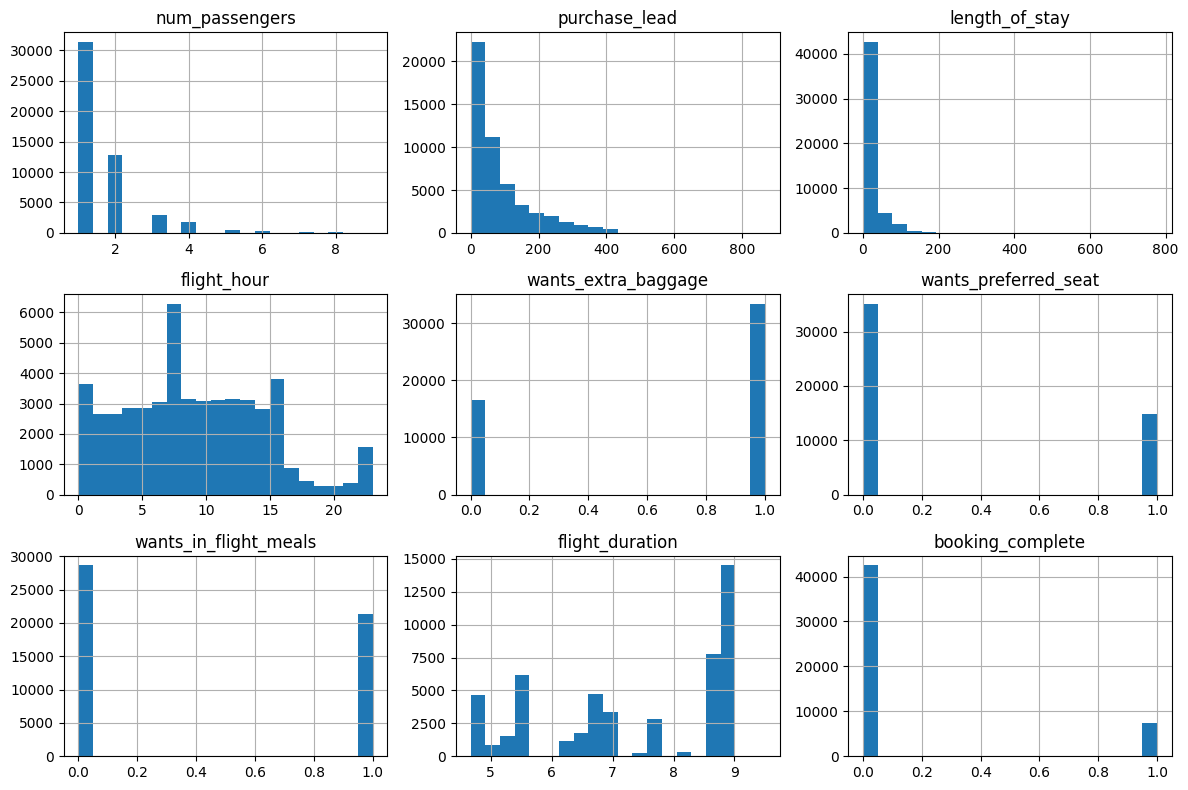

In [11]:
# Visualizing numerical features
df.select_dtypes(include=['int64', 'float64']).hist(
    figsize=(12, 8),
    bins=20)
plt.tight_layout()
plt.show()

This is good to see distributions and determine (if we need to) if there needs to be any data cleaning or imputation using mean, median, or mode. We must also note the target variable booking_complete. It seems that it has more 0's than 1's, reflecting a class imbalance. **This class imbalance will have to be addressed later during training so the model can learn fairly and evenly from the data.**

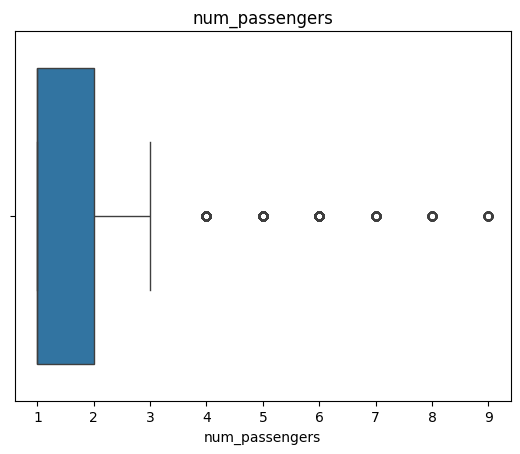

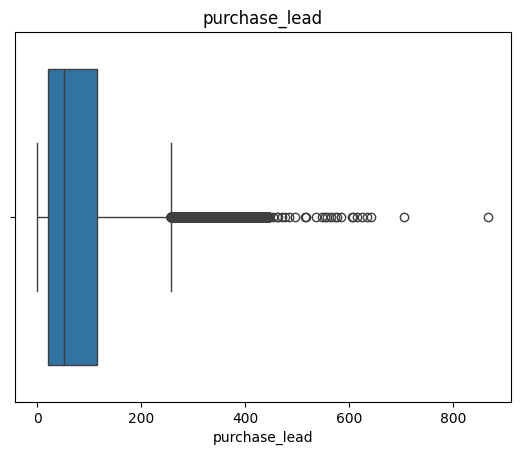

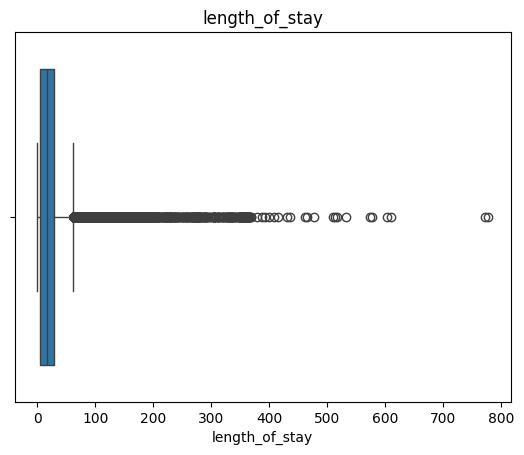

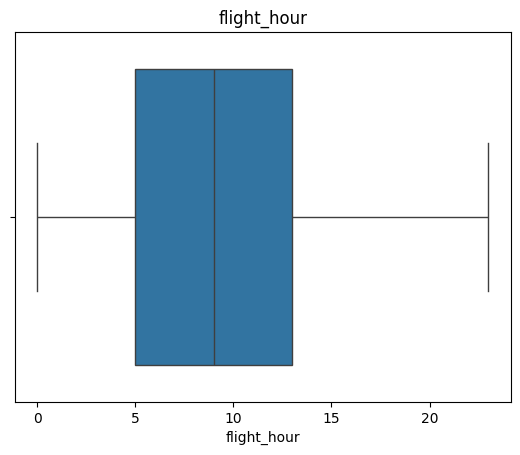

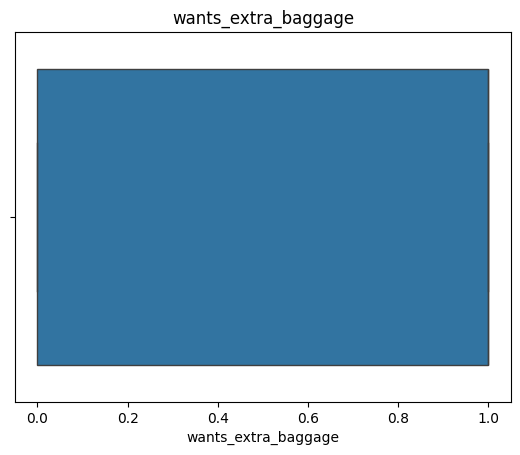

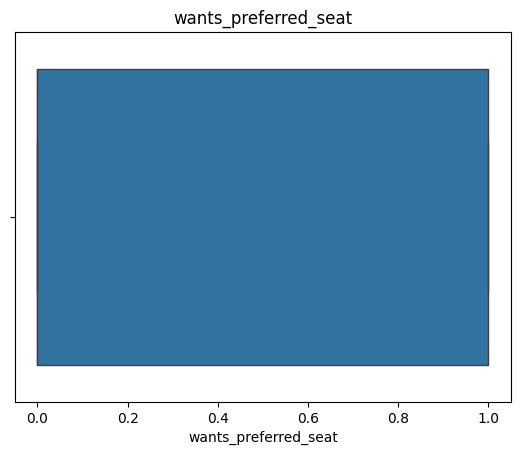

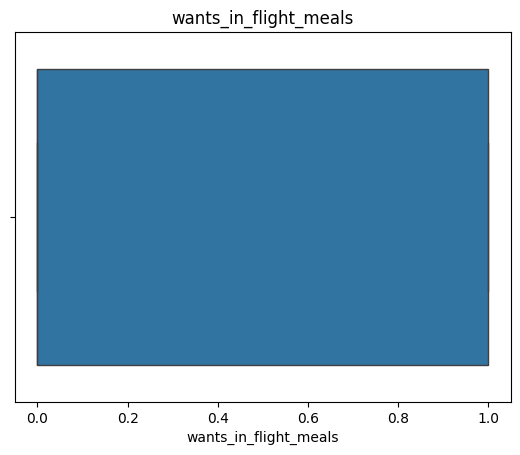

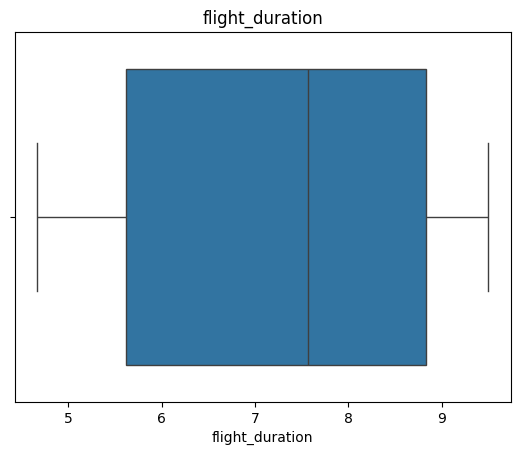

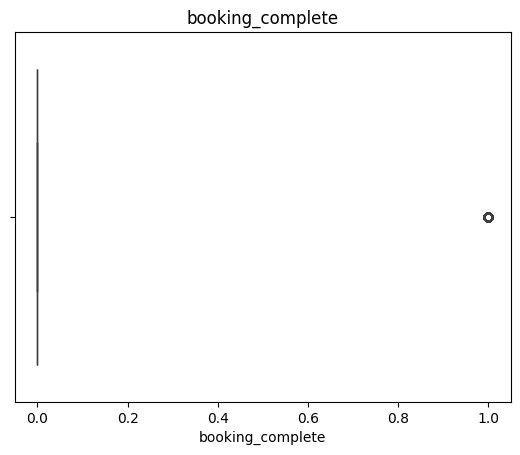

In [12]:
# Visualizing outliers for numerical features using a box plot
for col in df.select_dtypes(include=['int64', 'float64']).columns:
    plt.figure()
    sns.boxplot(x=df[col])
    plt.title(col)
    plt.show()

Sometimes it is also helpful to plot features against the target variable or do any conditional visualizing to see any patterns.

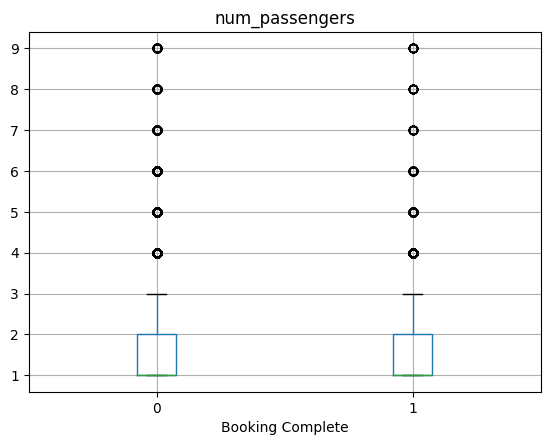

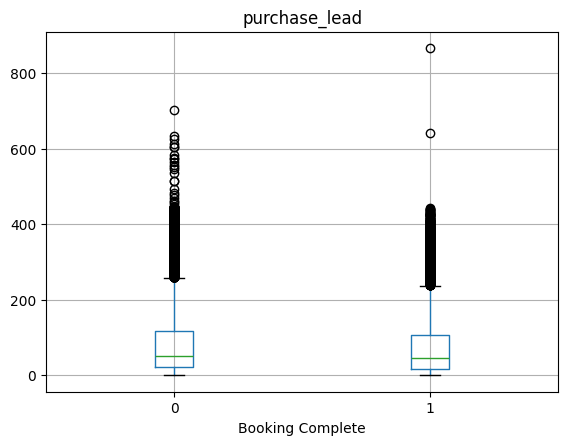

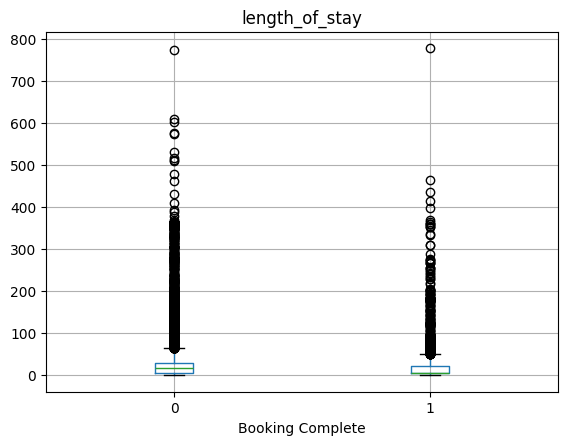

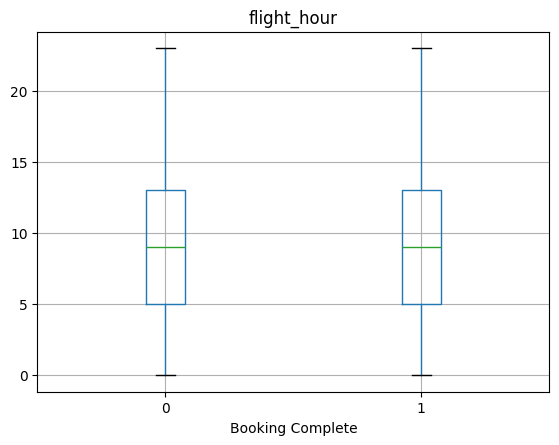

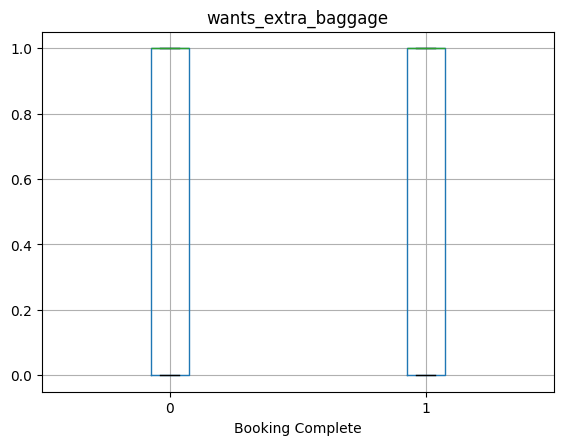

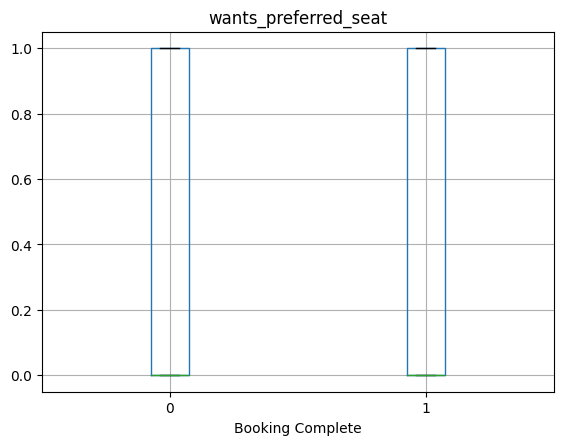

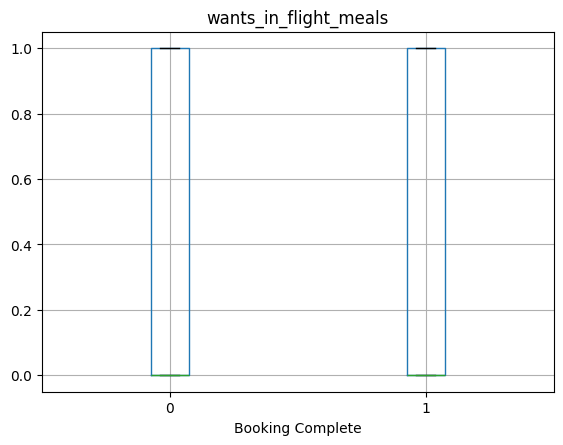

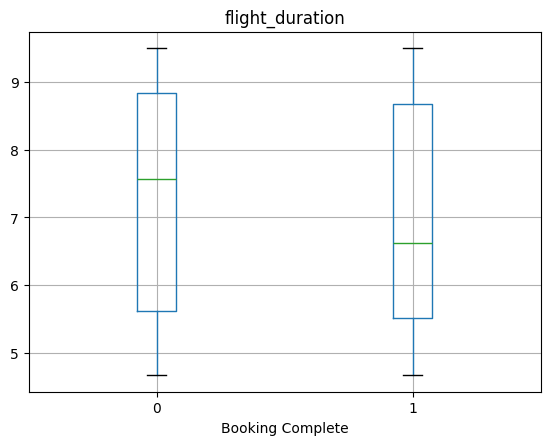

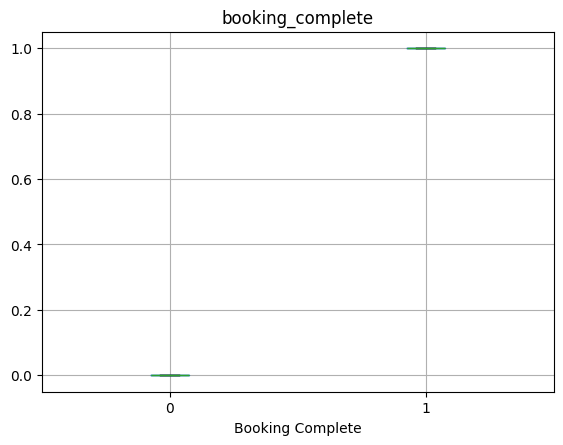

In [13]:
for col in df.select_dtypes(include=['int64', 'float64']).columns:
    df.boxplot(column=col, by='booking_complete')
    plt.title(col)
    plt.suptitle('')
    plt.xlabel('Booking Complete')
    plt.show()

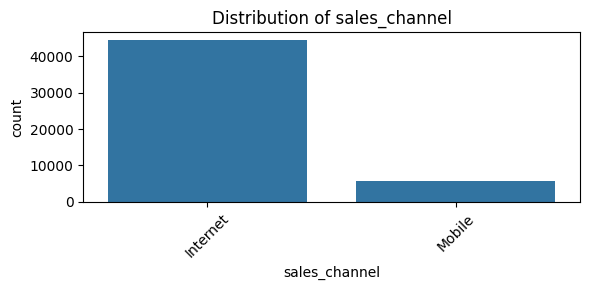

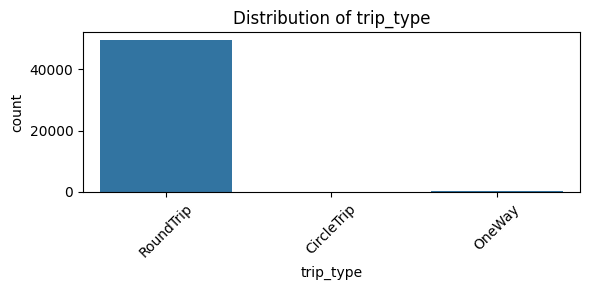

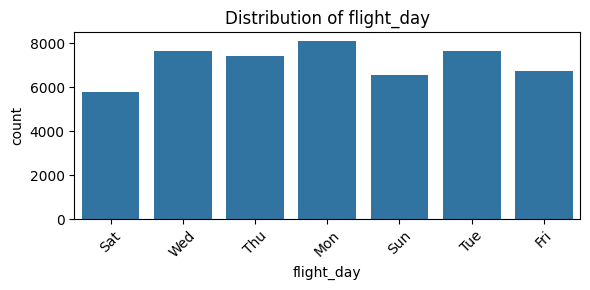

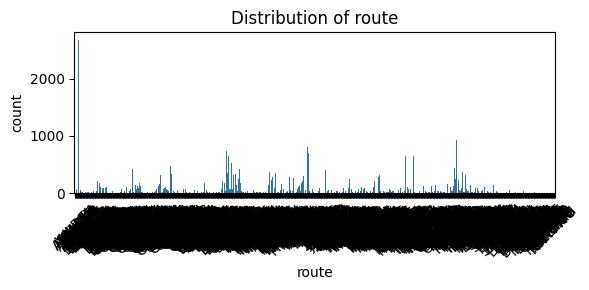

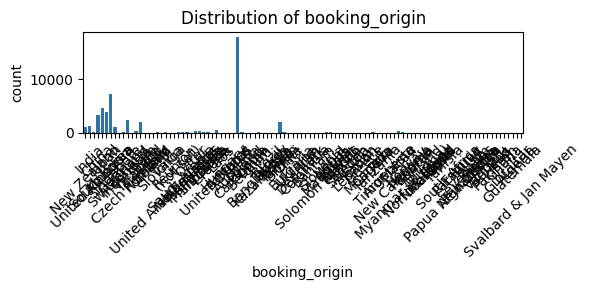

In [14]:
# Visualizing categorical features

categorical_cols = df.select_dtypes(include=['object']).columns
for col in categorical_cols:
    plt.figure(figsize=(6, 3))
    sns.countplot(data=df, x=col)
    plt.title(f'Distribution of {col}')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

Distributions of categorical features are always helpful and informative to see. If later we wanted to address any bias, knowing the distributions of these features would be the way to go. **Also note that for trip_type, there is barely any Circle trip types. This may have to be addressed later during training as well. Although this may be helpful for the data to learn as well (just because it is rare, doesn't mean it doesn't mean anything in patterns).**

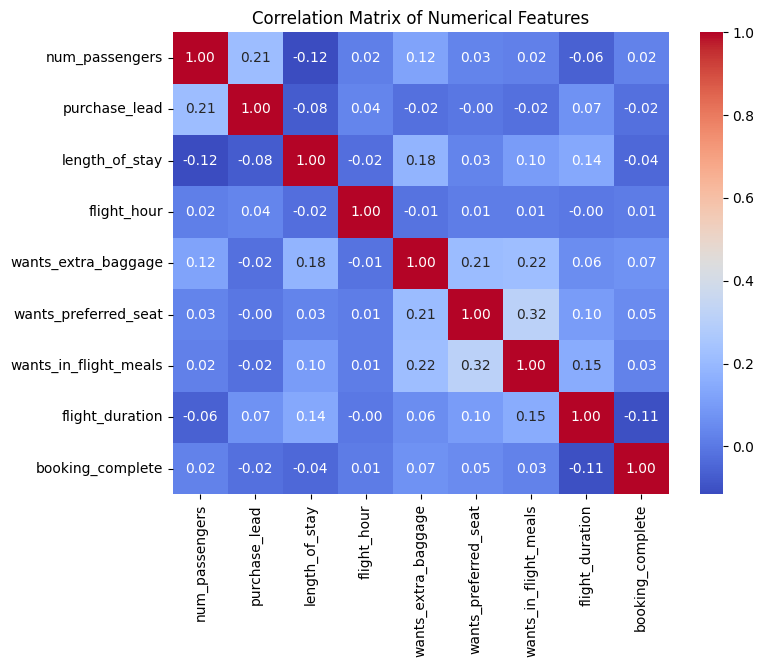

In [15]:
# Visualizing correlation to see if there is any multicollinearity to address (numerical features)

num_df = df.select_dtypes(include=['int64', 'float64'])
plt.figure(figsize=(8, 6))
sns.heatmap(
    num_df.corr(),
    annot=True,
    cmap='coolwarm',
    fmt=".2f")
plt.title('Correlation Matrix of Numerical Features')
plt.show()

Because correlation matrices are primarily for numerical data and our dataset is mostly categorical, this can be potentially misleading so take caution with this. But from a general viewpoint, it does not seem like anything is multicollinearated (anything with values above > 0.7/0.8 usually, depending on how strict you want to define the threshold).

**Usually after EDA and data viz exploration, I like to run a rough baseline model so I know what my initial statistics are and to compare if my data cleaning/feature engineering helped the model learn but since there is not really any data cleaning necessary except label encoding, we can skip this rough baseline part and just compare the 3 models after training.**

### **Part 4: Data cleaning and feature engineering, if needed**

For this part, we want to clean our data, fill in any missing variables (there are none so we do not have to worry about this part), and encode our categorical features based on one-hot encoding (there is no natural order/hierarchy) or label encoding (there is natural order/hierarchy), depending if there is a natural order or hierarchy in the variables. Also note that sometimes we do not want to one-hot encode if there are hundreds of unique variables for a feature because that would severely inflate our dataset which could skew data (like how there are many, many routes in the "route" feature).

**Encoding categorical features**

In [16]:
df.dtypes

# Encode sales_channel, trip_type, flight_day, route, and booking_origin

num_passengers             int64
sales_channel             object
trip_type                 object
purchase_lead              int64
length_of_stay             int64
flight_hour                int64
flight_day                object
route                     object
booking_origin            object
wants_extra_baggage        int64
wants_preferred_seat       int64
wants_in_flight_meals      int64
flight_duration          float64
booking_complete           int64
dtype: object

In [17]:
df.shape

(50000, 14)

Note that in the Getting Started notebook given as a resource to aid this task, the authors already did data conversion on the "flight_day" feature. We will follow what they did since they already did it.

In [18]:
# Encoding flight_day, copied over from the Getting started jupyter notebook 

mapping = {
    "Mon": 1,
    "Tue": 2,
    "Wed": 3,
    "Thu": 4,
    "Fri": 5,
    "Sat": 6,
    "Sun": 7,
}

df["flight_day"] = df["flight_day"].map(mapping)

So for sales_channel, there is only internet or mobile as variables. For trip type theres round trip, circle trip, and one way. For route there are hundreds and there is also a lot for booking_origin. I will encode based on this knowledge.

In [19]:
df = pd.get_dummies(df, columns=['sales_channel'], drop_first=True) # One-hot encoding for sales channel
df = pd.get_dummies(df, columns=['trip_type']) # One-hot encoding for trip type
from sklearn.preprocessing import LabelEncoder

labelencoder = LabelEncoder()
df['route'] = labelencoder.fit_transform(df['route']) # use label encoder function from sklearn preprocessing
df['booking_origin'] = labelencoder.fit_transform(df['booking_origin']) # Label encode for booking origin and route since there are thousands of unique variables here

In [20]:
df.shape # We noiw have 16 features rather than 14

(50000, 16)

**Feature engineering**

Feature engineering is also important. Feature engineering is basically creating new features by combining features to capture relationships. Feature engineering can also help reduce number of features if there are many. In our case, since we only have 14 detailed and no missing variables, this is already pretty good. If I want to later, I will go back and create some features that combine. Since machine learning and data science is iterative, it's always good to go back to previous steps to see if you can improve the model.

**Creating scaled and unscaled datasets for our models**

For our models, remember we are using Logistic regression (not robust to unscaled features, needs scaling), Random forest is robust to outliers (so it does not need scaling), and Gradient boosting is also robust (so it does not need scaling). We will create 2 datasets derived from our current df during training as scaled_df and unscaled_df.

### **Part 5: Split and train data**

Before training we must understand the workflow. This is the workflow for this pipeline: Full dataset > train/test split > CV on training set only > Final evluation on test set.

And because for cross-validation, we do not want any data-leakage, we can scale during cross-validation instead of beforehand. It's good to create a scaled dataset but since we are specifically doing cross-validation, we will not manually scale it beforehand. Scaling will be handled within the pipeline itself.

In [21]:
X = df.drop(columns=['booking_complete']) # To separate features and target
y = df['booking_complete']

X_train, X_test, y_train, y_test = train_test_split( # Train test split 80-20 where 80% of the data is train and 20% is test)
    X, y, test_size=0.2, random_state=42, stratify=y)

# Create scaled version
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Create unscaled version - we don't need this since we are doing cross-validation
# X_train_unscaled = X_train.copy()
# X_test_unscaled = X_test.copy()

### **Part 6: Testing and cross-validation**

In [22]:
# Testing and CV pipeline for logistic regression (scaling needed)
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42) # CV strategy

lr_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('clf', LogisticRegression(class_weight='balanced', max_iter=1000))]) # Addressed class imbalance here by doing class_weight=balanced

lr_scores = cross_val_score(
    lr_pipeline,
    X_train,
    y_train,
    cv=cv,
    scoring='roc_auc')  # ROC-AUC is better for imbalanced data

print("Logistic Regression ROC-AUC:", np.mean(lr_scores))

Logistic Regression ROC-AUC: 0.658268305208497


That's not the final report but ROC=0.66 is pretty decent. Since this is a binary classification problem, we are going to want to look at ROC-AUC (which is good for imbalanced data), F1, Recall, Precision, and Accuracy. Which metric is the most important will be determined later. There is a way to determine that.

In [23]:
# Testing and CV for random forest (scaling not needed)

rf = RandomForestClassifier(
    n_estimators=200,
    random_state=42,
    class_weight='balanced')

rf_scores = cross_val_score(
    rf,
    X_train,
    y_train,
    cv=cv,
    scoring='roc_auc')

print("Random Forest ROC-AUC:", np.mean(rf_scores))

Random Forest ROC-AUC: 0.7669517086132674


ROC-AUC for random forest being 0.767 is pretty good! Let's check XGBoost which is a gradient boosting tree model and usually more powerful than basic decision trees.

In [24]:
# Testing and CV for XGBoost (scaling not needed but we do need to make scale_pos_weight to address class imbalance)
# Compute scale_pos_weight
scale_pos_weight = y_train.value_counts()[0] / y_train.value_counts()[1]

xgb = XGBClassifier(
    n_estimators=200,
    random_state=42,
    eval_metric='logloss',  # avoids warning
    scale_pos_weight=scale_pos_weight)

xgb_scores = cross_val_score(
    xgb,
    X_train,
    y_train,
    cv=cv,
    scoring='roc_auc')

print("XGBoost ROC-AUC:", np.mean(xgb_scores))

XGBoost ROC-AUC: 0.7621456522924162


**Fit the data for testing**

In [25]:
# Logistic Regression
lr_pipeline.fit(X_train, y_train)

# Random Forest
rf.fit(X_train, y_train)

# XGBoost
xgb.fit(X_train, y_train)

,objective,'binary:logistic'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,None
,device,None
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,'logloss'


### **Part 7: Evaluation**

Choosing a metric to focus on always depends on what the goal of the problem is and the problem itself. For example, having a good recall score is mostly preferred in a medical dataset because recall looks at false-negatives (and hospitals do not want to label a patient not having a deadly illness, when in fact, they do). Precision focuses on false positives and can help save on resources. F1 is a balance between recall and precision. Accuracy is how many were correct predictions and ROC-AUC focuses on how well the model can discriminate between the target variables (how well it can determine if someone will book or not or if it is just memorizing the data or predicting because it learned how class 0's acted more than class 1's).

For this task, it depends. If BA wants to maximize the number of customers they reach who actually book, recall would probably be more important. If BA wants to avoid wasting resources on customers unlikely to book, precision might be more important. In general, ROC-AUC is a pretty good overall metric to compare models. I will compare ROC-AUC, recall, precision, F1, and accuracy between the 3 models and then choose the best performing with a focus on recall (because if a person booked and the airlines missed them, that could be bad) and F1 (to balance false negatives and false positives) and also ROC-AUC. Precision and accuracy will be secondary metrics to be considered.

**Evaluate on test set**

In [27]:
models = {
    "Logistic Regression": (lr_pipeline, X_test),
    "Random Forest": (rf, X_test),
    "XGBoost": (xgb, X_test)}

results = []
for name, (model, X) in models.items():
    y_pred = model.predict(X)
    y_proba = model.predict_proba(X)[:, 1]

    results.append({
        "Model": name,
        "ROC-AUC": roc_auc_score(y_test, y_proba),
        "Recall": recall_score(y_test, y_pred),
        "Precision": precision_score(y_test, y_pred),
        "F1": f1_score(y_test, y_pred),
        "Accuracy": accuracy_score(y_test, y_pred)})

results_df = pd.DataFrame(results)

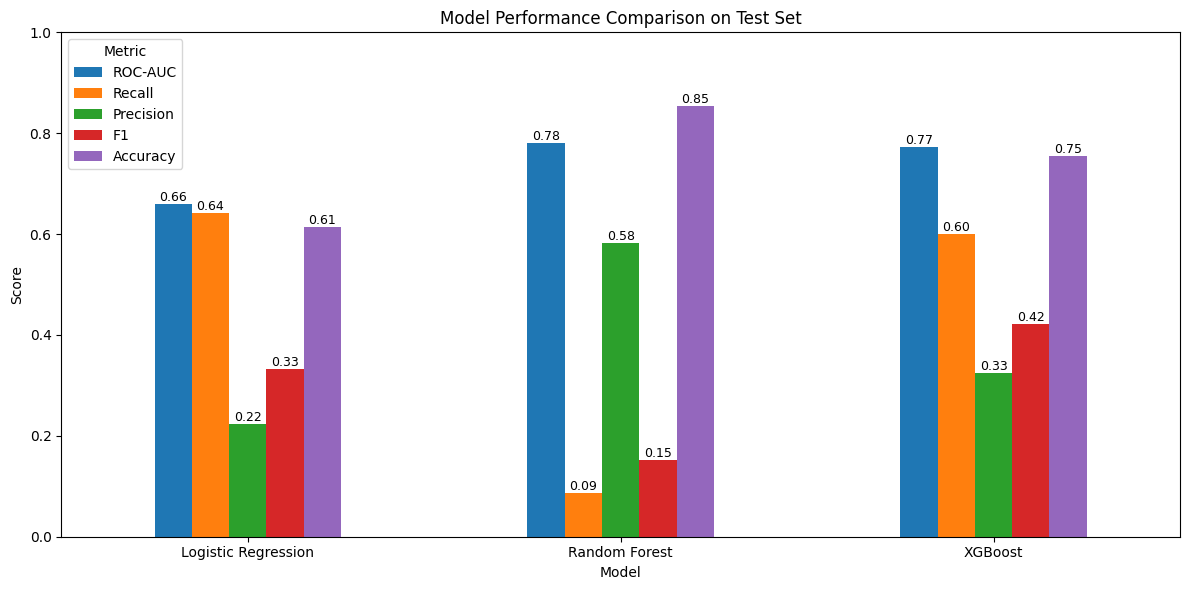

In [29]:
# Choose best model (visualize metrics comparing the 3 models)

metrics = ["ROC-AUC", "Recall", "Precision", "F1", "Accuracy"]

ax = results_df.set_index("Model")[metrics].plot(
    kind="bar",
    figsize=(12, 6))

plt.title("Model Performance Comparison on Test Set")
plt.ylabel("Score")
plt.ylim(0, 1)
plt.xticks(rotation=0)
plt.legend(title="Metric")

# Add values
for container in ax.containers:
    ax.bar_label(container, fmt="%.2f", label_type="edge", fontsize=9)
plt.tight_layout()
plt.show()

- ROC-AUC: Random Forest has the best score
- Recall: Logistic Regression
- F1: XGBoost
- Precision: XGBoost
- Accuracy: Random Forest

From these scores, it seems that the XGBoost has well-balanced results. For example, where Random Forest recall is very low and logistic regression recall is at 0.64, XGBoost has a recall of 0.6 AND a good ROC-AUC of 0.77. **XGBoost is our best performing model here**.

In [31]:
# Output classification report and confusion matrix for best model - XGBoost

print("Classification Report (XGBoost):\n")
print(classification_report(y_test, y_pred))

Classification Report (XGBoost):

              precision    recall  f1-score   support

           0       0.92      0.78      0.84      8504
           1       0.33      0.60      0.42      1496

    accuracy                           0.75     10000
   macro avg       0.62      0.69      0.63     10000
weighted avg       0.83      0.75      0.78     10000



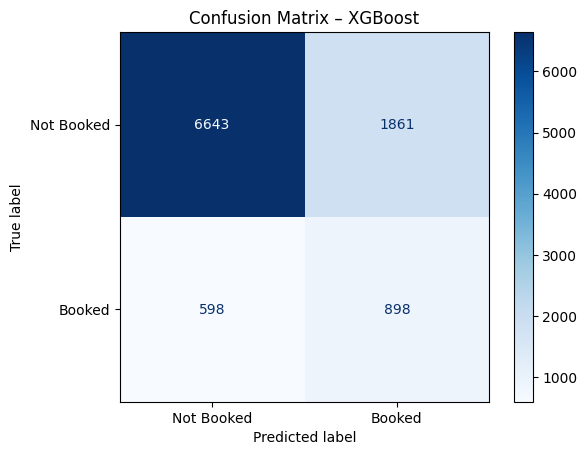

In [32]:
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(
    confusion_matrix=cm,
    display_labels=["Not Booked", "Booked"])

disp.plot(cmap="Blues")
plt.title("Confusion Matrix – XGBoost")
plt.show()

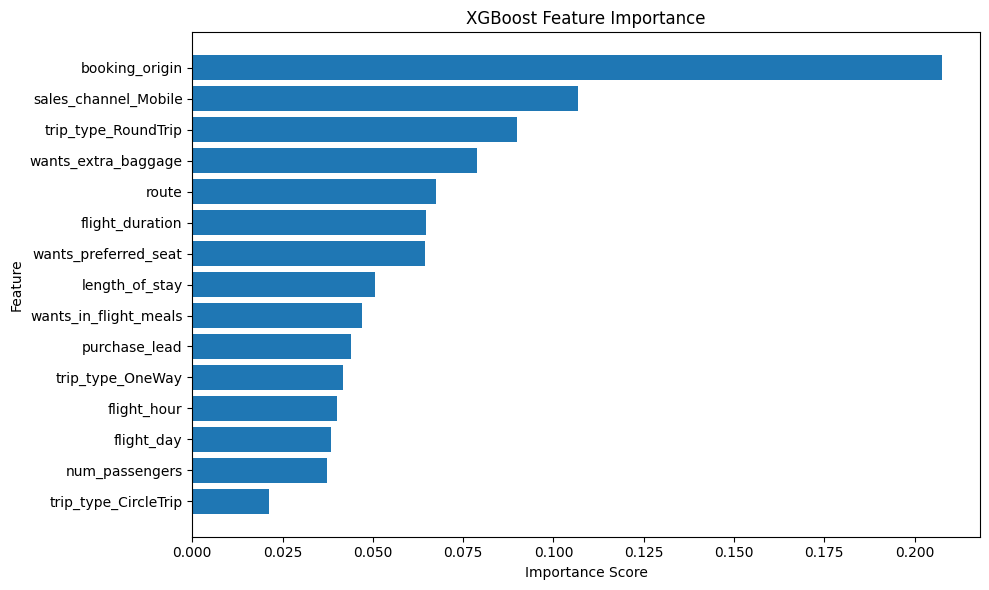

In [33]:
# Output feature importance on best model - XGBoost (using gain-based importance)

# Get feature importance values
importance = xgb.feature_importances_

# Create DataFrame
feature_importance_df = pd.DataFrame({
    "Feature": X_train.columns,
    "Importance": importance
}).sort_values(by="Importance", ascending=False)

# Plot top features
plt.figure(figsize=(10, 6))
plt.barh(
    feature_importance_df["Feature"],
    feature_importance_df["Importance"])
plt.gca().invert_yaxis()
plt.title("XGBoost Feature Importance")
plt.xlabel("Importance Score")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()

The feature importance plot shows that booking origin, someone purchasing a ticket on their mobile device, round trip flights, customers who want extra baggage, and the route contribute most strongly to the model’s predictive power.

### **Part 8: Conclusion**

The model shows that booking behavior and travel structure such as booking origin, mobile usage, trip type, and route are stronger predictors of booking completion than ancillary preferences alone. This suggests that British Airways can more effectively drive conversions by targeting customers earlier in their booking journey based on behavioral and geographic signals.

- Customers booking via mobile and planning round-trip flights are more likely to complete bookings, indicating that mobile-optimized offers and targeted promotions for return travel may increase conversion rates
- Booking origin and route emerge as key predictors, suggesting that localized marketing campaigns and route-specific pricing strategies could be particularly effective
- While preferences such as extra baggage contribute less individually, they still provide incremental value and can be used to refine personalized offers once high-intent customers are identified
- 
These findings support a proactive, data-driven acquisition strategy where British Airways prioritizes high-intent customers early, rather than relying on reactive booking behavior at the airport or late in the customer journey.